<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw3_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [0]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 487 (delta 29), reused 34 (delta 12), pack-reused 429
Receiving objects: 100% (487/487), 53.89 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (209/209), done.
--2020-02-23 11:01:43--  https://docs.google.com/uc?export=download&confirm=JYXR&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 2607:f8b0:4005:80b::200e, 172.217.164.110
Connecting to docs.google.com (docs.google.com)|2607:f8b0:4005:80b::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-00-docs.googleusercontent.com/docs/securesc/h1mn3ue5e31refb02t7sfv26vkviqelu/pn2q9t0cp6s8b86c4bi3pifljb5ighlq/1582484400000/06419056966375271799/04349264662949066614Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-02-23 11:01:43--  https://doc-0k-00-docs.googleuse

In [0]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


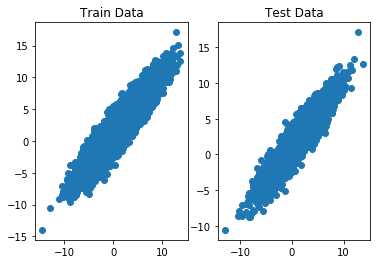

Dataset 2


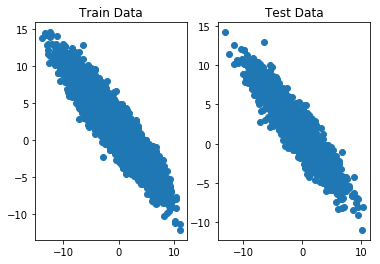

In [0]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses


class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)


class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2 * latent_dim, enc_hidden_sizes)
        self.decoder = MLP(latent_dim, 2 * input_dim, dec_hidden_sizes)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1).mean()

        # Compute KL
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()

In [0]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 

    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.4388, Recon Loss: 2.7630, KL Loss: 1.6758


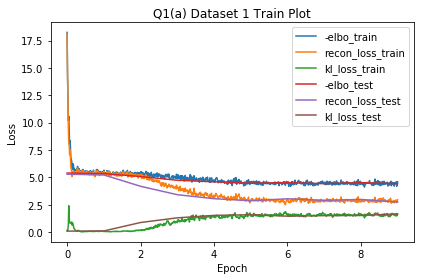

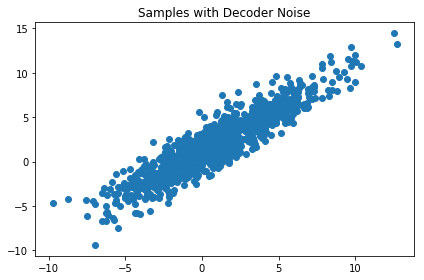

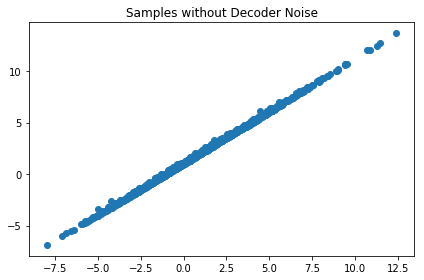

In [0]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.4488, Recon Loss: 2.8341, KL Loss: 1.6147


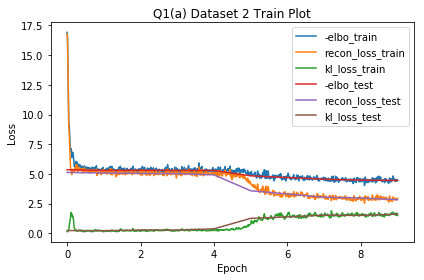

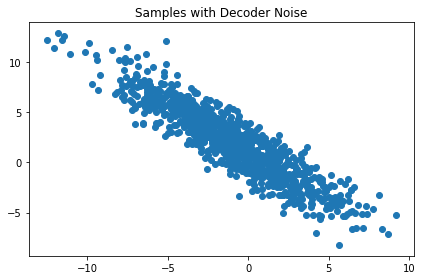

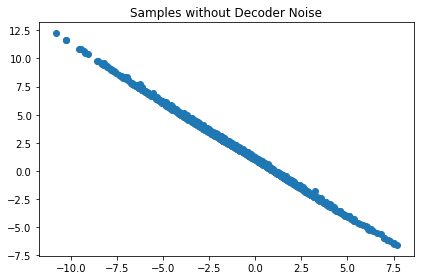

In [0]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


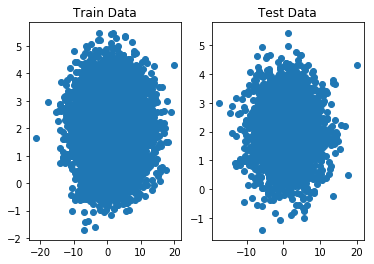

In [0]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 4.4213, Recon Loss: 4.4094, KL Loss: 0.0119


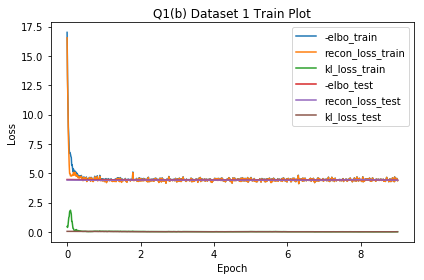

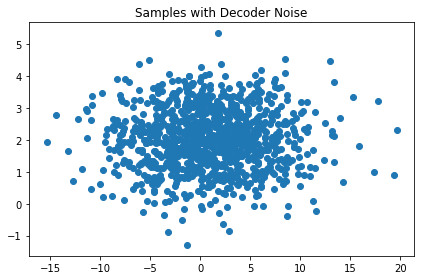

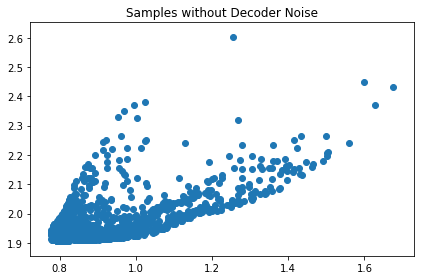

In [0]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4196, Recon Loss: 4.4123, KL Loss: 0.0073


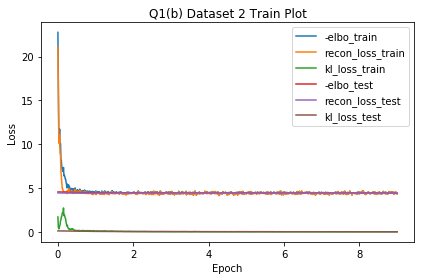

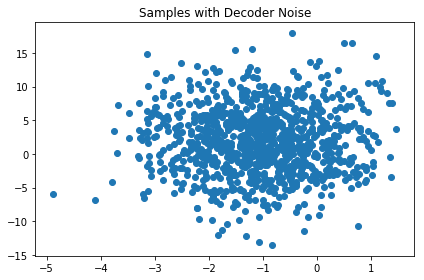

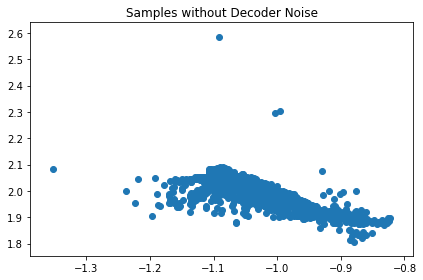

In [0]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

Answer: The latents are being used in part (a), but not in part (b). This is because the dataset in part (a) comes from a diagonal gaussian distribution so the decoder (also diagonal gaussian) can optimally model the data without the encoder / latents. However, for (a), the data come from a multivariate gaussian with non-diagonal covariance, so the encoder is used to achieve a better loss than without.

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

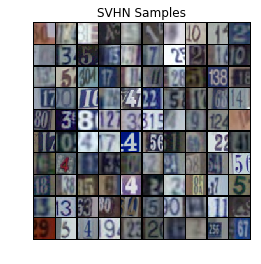

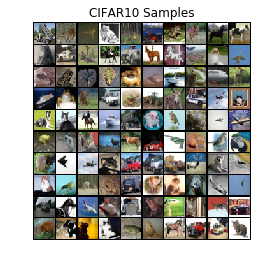

In [0]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        return out


class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def loss(self, x):
        x = 2 * x - 1
        mu, log_std = self.encoder(x)
        z = torch.randn_like(mu) * log_std.exp() + mu
        x_recon = self.decoder(z)

        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [0]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE((3, 32, 32), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 104.0417, Recon Loss: 79.3798, KL Loss: 24.6620


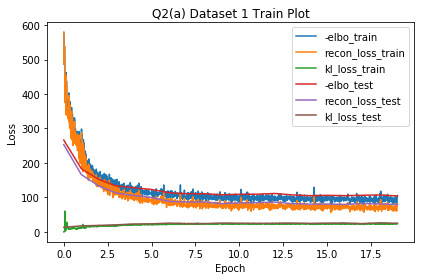

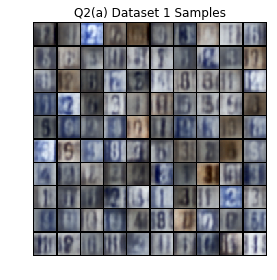

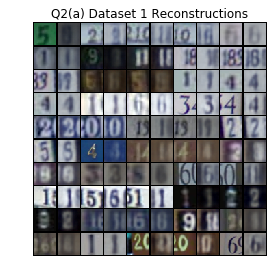

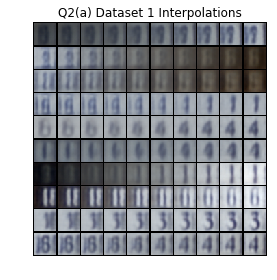

In [0]:
q2_save_results('a', 1, q2_a)

Final -ELBO: 241.6061, Recon Loss: 210.0690, KL Loss: 31.5371


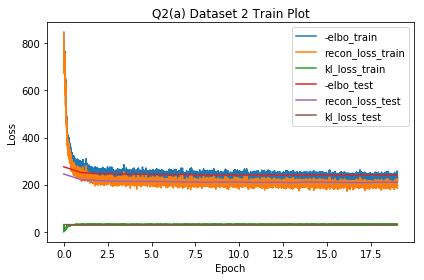

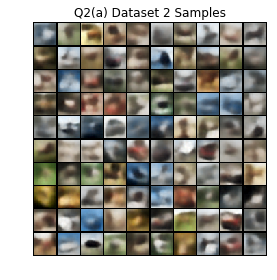

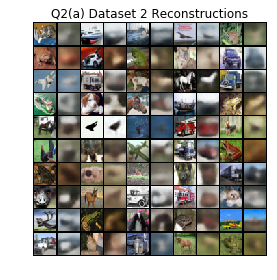

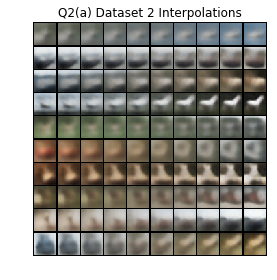

In [0]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\theta(z)$ and scale parameters $\sigma_\theta(z)$ and do the following transformation on $z$:
$$\epsilon = z * \sigma_\theta(z) + \mu_\theta(z)$$
and optimize the objective
$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True, conditional_size=None):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, out_features)

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input, cond=None):
        out = F.linear(input, self.mask * self.weight, self.bias)
        if cond is not None:
            out = out + self.cond_op(input)
        return out

class MADE(nn.Module):
    def __init__(self, input_shape, d, hidden_size=[512, 512], ordering=None,
                 conditional_size=None):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.d = d
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin) if ordering is None else ordering

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1, conditional_size=conditional_size),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.ModuleList(self.net)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            if isinstance(out, MaskedLinear):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out

class AFVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.latent_size = latent_size

        self.made = MADE(latent_size, 2, hidden_size=[512, 512])
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def loss(self, x):
        x = 2 * x.float() - 1
        mu_z, log_std_z = self.encoder(x)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        x_recon = self.decoder(z)

        recon_loss = F.mse_loss(x_recon, x, reduction='none').view(x.shape[0], -1).sum(1).mean()
        enc_log_prob = -0.5 * np.log(2 * np.pi) - log_std_z - 0.5 * (z - mu_z) ** 2 * torch.exp(-2 * log_std_z)

        out = self.made(z)
        mu, log_std = out.chunk(2, dim=-1)
        log_std = torch.tanh(log_std)
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
        eps = z * torch.exp(log_std) + mu
        prior_log_prob = -0.5 * np.log(2 * np.pi) + log_std - 0.5 * eps ** 2

        kl_loss = (enc_log_prob - prior_log_prob).sum(1).mean()
        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            for i in range(self.latent_size):
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
            return self.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [0]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = AFVAE((3, 32, 32), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = model.encoder(2 * x - 1)[0]
        x_recon = model.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    samples, reconstructions, interps = np.clip(samples, 0, 255), np.clip(reconstructions, 0, 255), np.clip(interps, 0, 255)

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 102.5659, Recon Loss: 80.2548, KL Loss: 22.3111


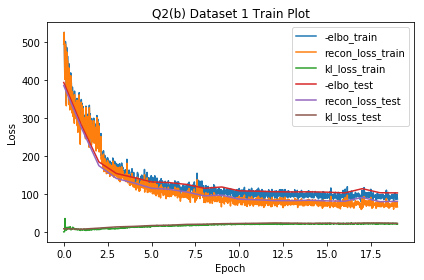

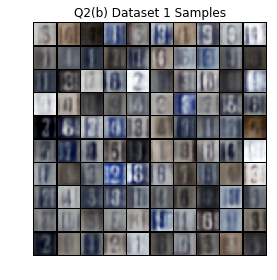

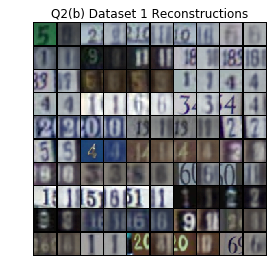

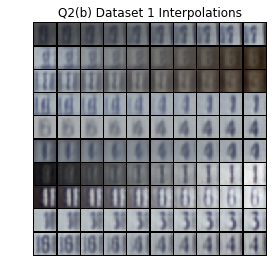

In [0]:
q2_save_results('b', 1, q2_b)

Final -ELBO: 238.9211, Recon Loss: 210.3319, KL Loss: 28.5892


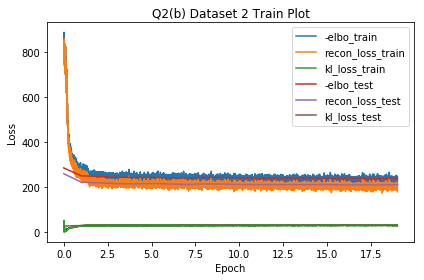

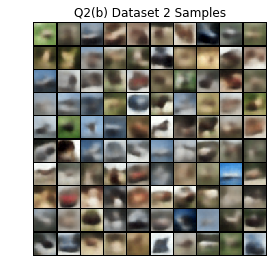

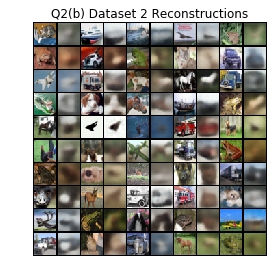

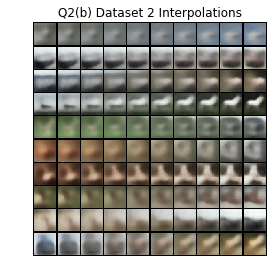

In [0]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   For dataset 1, use a single Type A masked convolutions followed by 10 residual blocks (same as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   For dataset 2, use the same architecture as above but with 15 residual blocks
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
      
    def forward(self, x):
        return x + self.net(x)

class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNNResBlock(nn.Module):
    def __init__(self, dim, conditional_size=None):
        super().__init__()
        self.block = nn.ModuleList([
            LayerNorm(dim),
            nn.ReLU(),
            MaskConv2d('B', dim, dim // 2, 1, conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim // 2, 3, padding=1, 
                       conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim, 1, conditional_size=conditional_size)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return x + out


class PixelCNN(nn.Module):
    def __init__(self, input_shape, code_size, dim=256, n_layers=7,
                 conditional_size=None):
        super().__init__()
        self.embedding = nn.Embedding(code_size, dim)
        model = nn.ModuleList([MaskConv2d('A', dim, dim, 7, padding=3,
                                          conditional_size=conditional_size),
                               LayerNorm(dim), nn.ReLU()])
        for _ in range(n_layers - 1):
            model.append(PixelCNNResBlock(dim, conditional_size=conditional_size))
        model.extend([LayerNorm(dim), nn.ReLU(), MaskConv2d('B', dim, 512, 1, conditional_size=conditional_size),
                      nn.ReLU(), MaskConv2d('B', 512, code_size, 1,
                                            conditional_size=conditional_size)])
        self.net = model
        self.input_shape = input_shape
        self.code_size = code_size

    def forward(self, x, cond=None):
        out = self.embedding(x).permute(0, 3, 1, 2).contiguous()
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, PixelCNNResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out

    def loss(self, x, cond=None):
        return OrderedDict(loss=F.cross_entropy(self(x, cond=cond), x))

    def sample(self, n, cond=None):
        samples = torch.zeros(n, *self.input_shape).long().cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples, cond=cond)[:, :, r, c]
                    logits = F.softmax(logits, dim=1)
                    samples[:, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples


class Quantize(nn.Module):

    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim)
        self.embedding.weight.data.uniform_(-1./size,1./size)

        self.code_dim = code_dim
        self.size = size

    def forward(self, z):
        b, c, h, w = z.shape
        weight = self.embedding.weight

        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices


class VectorQuantizedVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.codebook = Quantize(code_size, code_dim)

        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode_code(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)

        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return x_tilde, diff1 + diff2

    def loss(self, x):
        x = 2 * x - 1
        x_tilde, diff = self(x)
        recon_loss = F.mse_loss(x_tilde, x)
        loss = recon_loss + diff
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)

In [0]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')

    code_dim, code_size = 256, 128
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3, grad_clip=1), quiet=True)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda()
                z = vqvae.encode_code(x)
                prior_data.append(z.long())
        return torch.cat(prior_data, dim=0)

    prior = PixelCNN(code_size=code_size, input_shape=(8, 8), dim=128, n_layers=10).cuda()
    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader)
    prior_train_loader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True)
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=128)
    prior_train_losses, prior_test_losses = train_epochs(prior, prior_train_loader, prior_test_loader,
                                                         dict(epochs=15, lr=1e-3, grad_clip=1), quiet=True)
    prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

    samples = prior.sample(100).long()
    samples = vqvae.decode_code(samples) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


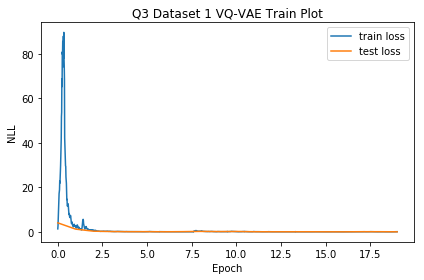

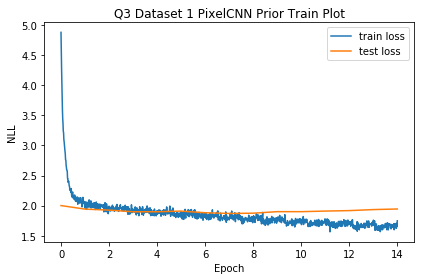

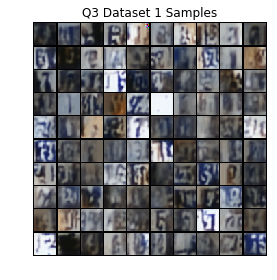

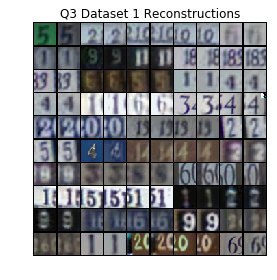

In [0]:
q3_save_results(1, q3)

VQ-VAE Final Test Loss: 0.0474
PixelCNN Prior Final Test Loss: 2.7528


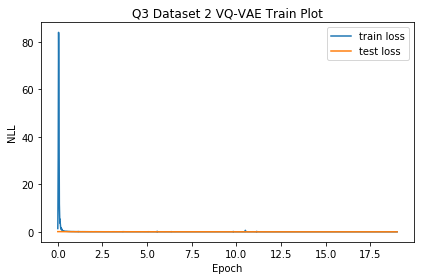

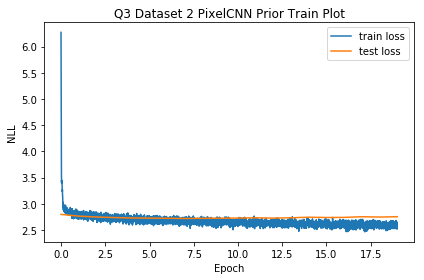

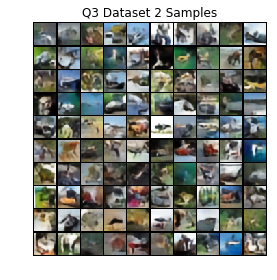

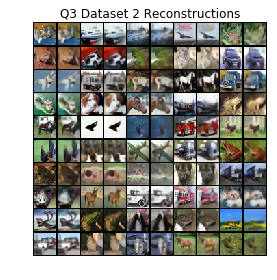

In [0]:
q3_save_results(2, q3)

# Question 4 Bonus [10pts]

## Part (a) Improving VQ-VAE Results [5pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
class StackLayerNorm(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.h_layer_norm = LayerNorm(n_filters)
    self.v_layer_norm = LayerNorm(n_filters)

  def forward(self, x):
    vx, hx = x.chunk(2, dim=1)
    vx, hx = self.v_layer_norm(vx), self.h_layer_norm(hx)
    return torch.cat((vx, hx), dim=1)

class GatedConv2d(nn.Module):
  def __init__(self, mask_type, in_channels, out_channels, k=7, padding=3):
    super().__init__()

    self.vertical = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=k,
                              padding=padding, bias=False)
    self.horizontal = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=(1, k),
                                padding=(0, padding), bias=False)
    self.vtoh = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1, 
                            bias=False)
    self.htoh = nn.Conv2d(out_channels, out_channels, kernel_size=1, 
                            bias=False)


    self.register_buffer('vmask', self.vertical.weight.data.clone())
    self.register_buffer('hmask', self.horizontal.weight.data.clone())

    self.vmask.fill_(1)
    self.hmask.fill_(1)

    # zero the bottom half rows of the vmask
    # No need for special color condition masking here since we get to see everything
    self.vmask[:, :, k // 2 + 1:, :] = 0

    # zero the right half of the hmask
    self.hmask[:, :, :, k // 2 + 1:] = 0
    if mask_type == 'A':
      self.hmask[:, :, :, k // 2] = 0
  
  def down_shift(self, x):
    x = x[:, :, :-1, :]
    pad = nn.ZeroPad2d((0, 0, 1, 0))
    return pad(x)

  def forward(self, x):
    vx, hx = x.chunk(2, dim=1)

    self.vertical.weight.data *= self.vmask
    self.horizontal.weight.data *= self.hmask

    vx = self.vertical(vx)
    hx_new = self.horizontal(hx)
    # Allow horizontal stack to see information from vertical stack
    hx_new = hx_new + self.vtoh(self.down_shift(vx))

    # Gates
    vx_1, vx_2 = vx.chunk(2, dim=1)
    vx = torch.tanh(vx_1) * torch.sigmoid(vx_2)

    hx_1, hx_2 = hx_new.chunk(2, dim=1)
    hx_new = torch.tanh(hx_1) * torch.sigmoid(hx_2)
    hx_new = self.htoh(hx_new)
    hx = hx + hx_new

    return torch.cat((vx, hx), dim=1)

# GatedPixelCNN using horizontal and vertical stacks to fix blind-spot
class GatedPixelCNN(nn.Module):
  def __init__(self, input_shape, code_size, dim=256, n_layers=7):
    super().__init__()
    self.n_channels = input_shape[0]
    self.input_shape = input_shape
    self.code_size = code_size

    self.embedding = nn.Embedding(code_size, dim)
    self.in_conv = MaskConv2d('A', dim, dim, 7, padding=3)
    model = []
    for _ in range(n_layers - 2):
      model.extend([nn.ReLU(), StackLayerNorm(dim), GatedConv2d('B', dim, dim, 7, padding=3)])
    model.extend([nn.ReLU(), StackLayerNorm(dim)])
    self.out_conv = MaskConv2d('B', dim, code_size, 7, padding=3)
    self.net = nn.Sequential(*model)

  def forward(self, x):
    batch_size = x.shape[0]
    out = self.embedding(x).permute(0, 3, 1, 2).contiguous()
    out = self.in_conv(out)
    out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1]
    out = self.out_conv(out)
    return out
  
  def loss(self, x):
    return OrderedDict(loss=F.cross_entropy(self(x), x.long()))

  def sample(self, n):
    samples = torch.zeros(n, *self.input_shape).long().cuda()
    with torch.no_grad():
      for r in range(self.input_shape[0]):
        for c in range(self.input_shape[1]):
            logits = self(samples)[:, :, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples

In [0]:
def q4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')

    code_dim, code_size = 256, 128
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3, grad_clip=1), quiet=True)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda()
                z = vqvae.encode_code(x)
                prior_data.append(z.long())
        return torch.cat(prior_data, dim=0)

    prior = GatedPixelCNN(code_size=code_size, input_shape=(8, 8), dim=128, n_layers=15).cuda()
    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader)
    prior_train_loader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True)
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=128)
    prior_train_losses, prior_test_losses = train_epochs(prior, prior_train_loader, prior_test_loader,
                                                         dict(epochs=10, lr=1e-3, grad_clip=1), quiet=True)
    prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

    samples = prior.sample(100).long()
    samples = vqvae.decode_code(samples) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0557
PixelCNN Prior Final Test Loss: 2.8675


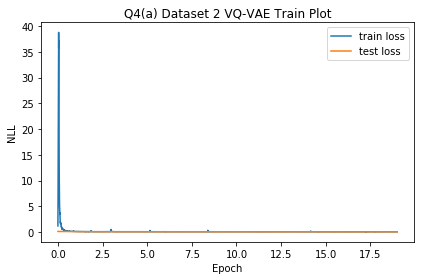

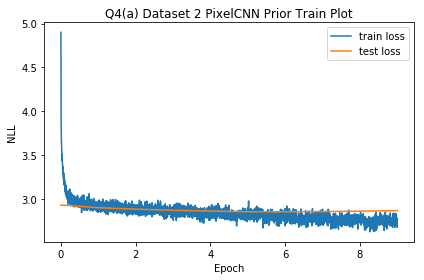

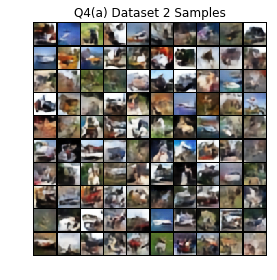

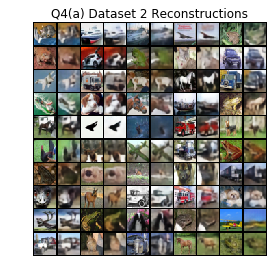

In [0]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [0]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, dim=256, n_layers=7, 
                 k=3, conditional_size=None):
        super().__init__()
        self.n_colors = n_colors
        self.input_shape = input_shape
        model = nn.ModuleList([MaskConv2d('A', input_shape[0], dim, k, padding=k // 2,
                                          conditional_size=conditional_size),
                               LayerNorm(dim), nn.ReLU()])
        for _ in range(n_layers - 1):
            model.append(MaskConv2d('B', dim, dim, k, padding=k // 2, 
                                    conditional_size=conditional_size))
        model.extend([LayerNorm(dim), nn.ReLU(),
                      MaskConv2d('B', dim, n_colors, 1, conditional_size=conditional_size)])
        self.net = model

    def forward(self, x, cond=None):
        out = 2 * (x.float() / (self.n_colors - 1)) - 1
        for layer in self.net:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out.view(x.shape[0], self.n_colors, *self.input_shape)

    def loss(self, x, cond=None):
        return F.cross_entropy(self(x, cond=cond), x.long(), reduction='none').view(x.shape[0], -1).sum(1).mean()

    def sample(self, n, cond=None):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.input_shape[0]):
                        logits = self(samples, cond=cond)[:, :, k, r, c]
                        logits = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 4 * input_shape[2] // 4 * 128
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std


class PixelVAE(nn.Module):
    def __init__(self, input_shape, latent_size, free_bits=10):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = PixelCNN(input_shape, 2, dim=64, n_layers=8,
                                k=7, conditional_size=latent_size)
        self.free_bits = free_bits

    def loss(self, x):
        x_scaled = 2 * x - 1
        mu, log_std = self.encoder(x_scaled)
        z = torch.randn_like(mu) * log_std.exp() + mu
        recon_loss = self.decoder.loss(x, cond=z)
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = torch.clamp(kl_loss.sum(1), min=self.free_bits).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = self.decoder.sample(n, cond=z)
        return samples

In [0]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype('float32')
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype('float32')

    model = PixelVAE((1, 28, 28), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100)

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z, _ = model.encoder(2 * x - 1)
        x_recon = model.decoder.sample(50, cond=z)
    x = x.permute(0, 2, 3, 1).cpu().numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 28, 28, 1))

    return train_losses, test_losses, samples, reconstructions

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

Final -ELBO: 85.9264, Recon Loss: 60.1186, KL Loss: 25.8078


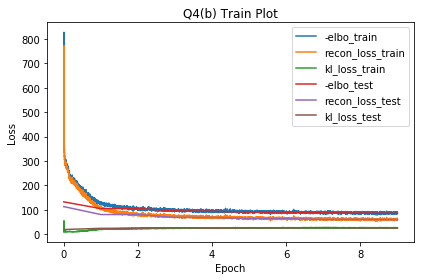

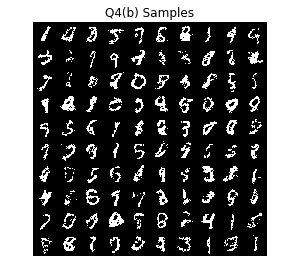

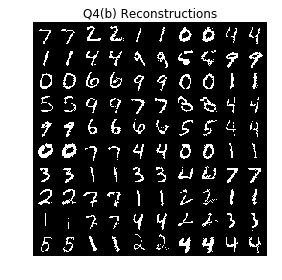

In [0]:
q4_b_save_results(q4_b)

# File Saving Utility


In [0]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)